In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import math as math
from scipy import stats
import numpy as np
import importlib
import project_functions
import seaborn as sns

In [ ]:
df_conv=pd.read_csv('df_conv.csv')
df_error_counter=pd.read_csv("df_error_counter.csv")


In [ ]:
df_time= pd.read_csv("vanguard - process step diff and step time per client id, per visit_id.csv")

In [ ]:
df_exp = pd.read_csv("df_exp_clean.csv")

In [ ]:
df_error_counter

,Unnamed: 0,variation,conversion,total,proportion
0,0,control,6358,143420,0.044331
1,1,test,11838,177787,0.066585


## Z-test proportion test 

Based on https://towardsdatascience.com/a-b-testing-with-binary-data-two-sample-proportions-z-test-5c222d7772ad!

In [ ]:
def create_df_ztest(df,stat):
    pd.DataFrame({
    'variation': ['control', 'test'], 
    'conversion': [
        
        sum(df[df['variation'] == 'Control'].stat),
        sum(df[df['variation'] == 'Test'].stat)
    ], 
  
    'total': [

        len(df[df['variation'] == 'Control']),
        len(df[df['variation'] == 'Test'])],

    'proportion':[
        sum(df[df['variation'] == 'Control'].stat) / len(df[df['variation'] == 'Control']),
        sum(df[df['variation'] == 'Test'].stat) / len(df[df['variation'] == 'Test'])
    ]
})

In [ ]:
#probably useless
#error_counter_ztest(df_error_counter,"error")

NameError: name 'error_counter_ztest' is not defined

In [ ]:
#probably useless
# create data frame with counts of conversion in test and control group with extra column with total counts per sample
df_ztest = pd.DataFrame({
    'variation': ['control', 'test'], 
    'conversion': [
        
        sum(df_conv[df_conv['variation'] == 'Control'].conversion),
        sum(df_conv[df_conv['variation'] == 'Test'].conversion)
    ], 
  
    'total': [

        len(df_conv[df_conv['variation'] == 'Control']),
        len(df_conv[df_conv['variation'] == 'Test'])],

    'proportion':[
        sum(df_conv[df_conv['variation'] == 'Control'].conversion) / len(df_conv[df_conv['variation'] == 'Control']),
        sum(df_conv[df_conv['variation'] == 'Test'].conversion) / len(df_conv[df_conv['variation'] == 'Test'])
    ]
})

In [ ]:
df_ztest

,variation,conversion,total,proportion
0,control,15201,23527,0.646109
1,test,18333,26961,0.679982


In [ ]:
df_error_counter

,Unnamed: 0,variation,conversion,total,proportion
0,0,control,6358,143420,0.044331
1,1,test,11838,177787,0.066585


In [ ]:
#run proportion test
#proportions_ztest(count=[18333, 15201], nobs=[26959,23527], alternative='larger')

(27.12298779001062, 2.6376195787310787e-162)

In [ ]:
# Z-test definitions: 

# p1 = proportion of successes in sample 1 (control group)
# p2 = proportion of successes in sample 2 (test group)

# n1 = number of trials in sample 1
# n2 = number of trials in sample 2

#The null hypothesis states that there is no difference in the proportions, while 
#the alternative hypothesis says that proportion 1 is less than proportion 2. I.e., there is an effect of the new design.

# H0: p1 = p2
# H1: p1 < p2 (left-tailed test)

In [ ]:
 # Estimate sample size for z-test

 def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))
def sample_required(p1, p_diff, alpha):
    if p_diff <= 0:  # p_diff = p2-p1
        raise ValueError("p_diff must be > 0")
    n = 1
    while True:
        z = z_calc(p1, p1+p_diff, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n
sample_size = sample_required(df_ztest[['proportion'][0]][0],
                             (df_ztest[['proportion'][0]][1] -       df_ztest[['proportion'][0]][0]),
0.05)

sample_size

1054

The minimum sample size is 1051 for each group. (this is an extra step - in our case the samples were very big anyway)

In [ ]:
# Create new data frame with random sample for the z-test

df_tr = df_conv[df_conv['variation'] == 'Test']
df_ctrl = df_conv[df_conv['variation'] == 'Control']

In [ ]:
df_tr_sample = df_tr.sample(n=20000, random_state=23)
df_ctrl_sample = df_ctrl.sample(n=20000, random_state=23)

In [ ]:
df_sample = pd.concat([df_tr_sample, df_ctrl_sample], ignore_index=True)
df_sample.head(2)


,Unnamed: 0,client_id,confirm,start,step_1,step_2,step_3,conversion,completed_&_confused,completed_linear,variation
0,8347,1669156,1.0,3.0,1.0,1.0,1.0,1,0,0,Test
1,44148,8728781,1.0,1.0,1.0,1.0,1.0,1,0,1,Test


In [ ]:
df_sample_gr = df_sample.groupby('variation').agg({'conversion':'sum',
                                                    'client_id':'nunique'}).reset_index()

In [ ]:
df_sample_gr['proportion'] = (df_sample_gr['conversion']) / df_sample_gr['client_id']


In [ ]:
df_sample_gr

,variation,conversion,client_id,proportion
0,Control,12899,20000,0.64495
1,Test,13626,20000,0.68130


### Z-test and results

In [ ]:
number_of_successes = [12899, 13626]
total_sample_sizes = [20000, 20000]

In [ ]:
test_stat, p_value = proportions_ztest(number_of_successes, total_sample_sizes, alternative='smaller')


In [ ]:
print("Computed z-test statistic: ", test_stat)
print("Computed p-value: ", p_value)


Computed z-test statistic:  -7.6908142674918025
Computed p-value:  7.310077118377838e-15


 In that case, we see that our result is statistically significant and we have evidence to reject the null hypothesis.

### Proportion z-test vs threshold 105%

In [ ]:
#df_sample_gr

threshold=(sum(df_conv[df_conv['variation'] == 'Control'].conversion) / len(df_conv[df_conv['variation'] == 'Control']))*1.05
threshold

0.6784141624516513

In [ ]:
# run z proportion test of test conversion vs p
# H0: p = p0
# H1: test > p

# Result cannot reject H0


proportions_ztest(count=18333, nobs=26959, value=threshold ,alternative='larger')


(0.5696937184289913, 0.2844427256392652)

### Duration per step testing

In [ ]:
import pandas as pd

In [ ]:
df_time.head()

,client_id,visit_id,date_time,process_step,Variation,step_ahead,diff,step_time
0,555,637149525_38041617439_716659,2017-04-15 12:57:56,start,Test,NaN,NaN,7.0
1,555,637149525_38041617439_716659,2017-04-15 12:58:03,step_1,Test,2017-04-15 12:57:56,7.0,32.0
2,555,637149525_38041617439_716659,2017-04-15 12:58:35,step_2,Test,2017-04-15 12:58:03,32.0,99.0
3,555,637149525_38041617439_716659,2017-04-15 13:00:14,step_3,Test,2017-04-15 12:58:35,99.0,20.0
4,555,637149525_38041617439_716659,2017-04-15 13:00:34,confirm,Test,2017-04-15 13:00:14,20.0,NaN


In [ ]:
df_time.shape

(11861, 8)

<AxesSubplot: ylabel='step_time'>

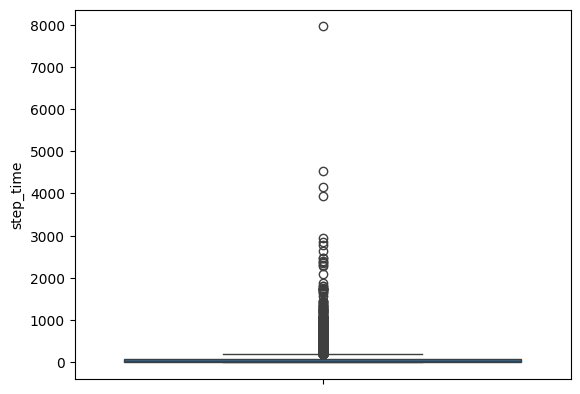

In [ ]:
# boxplot of step_time  
sns.boxplot(  y='step_time', data=df_time)

In [ ]:
# remove nulls from df_time step_time

df_time2 = df_time.dropna(subset=['step_time'])

df_time2['step_time'].describe()

count    9255.000000
mean       88.084927
std       212.636705
min         0.000000
25%        13.000000
50%        37.000000
75%        83.000000
max      7959.000000
Name: step_time, dtype: float64

<AxesSubplot: ylabel='step_time'>

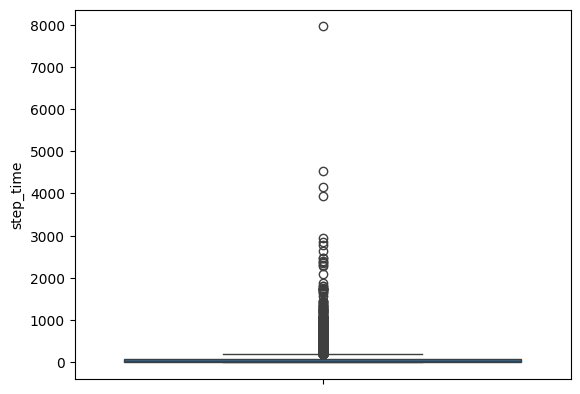

In [ ]:
#running again the boxplot
sns.boxplot(  y='step_time', data=df_time2)

In [ ]:
# Assigning 600 seconds max to the times >= 600s
df_time2['step_time'] = df_time2['step_time'].apply(lambda x : x if x < 600 else 600)


df_time2['step_time'].describe()

/tmp/ipykernel_91/4043602494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time2['step_time'] = df_time2['step_time'].apply(lambda x : x if x < 600 else 600)


count    9255.000000
mean       76.018585
std       114.955390
min         0.000000
25%        13.000000
50%        37.000000
75%        83.000000
max       600.000000
Name: step_time, dtype: float64

In [ ]:
df_time2.head()

,client_id,visit_id,date_time,process_step,Variation,step_ahead,diff,step_time
0,555,637149525_38041617439_716659,2017-04-15 12:57:56,start,Test,NaN,NaN,7.0
1,555,637149525_38041617439_716659,2017-04-15 12:58:03,step_1,Test,2017-04-15 12:57:56,7.0,32.0
2,555,637149525_38041617439_716659,2017-04-15 12:58:35,step_2,Test,2017-04-15 12:58:03,32.0,99.0
3,555,637149525_38041617439_716659,2017-04-15 13:00:14,step_3,Test,2017-04-15 12:58:35,99.0,20.0
5,647,40369564_40101682850_311847,2017-04-12 15:41:28,start,Test,NaN,NaN,7.0


In [ ]:
#DO NOT RUN
#removing outliers

def remove_outliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print("Lower Bound:", lower_bound)
    print("Upper Bound:", upper_bound)
    
    # Filter the DataFrame based on the condition
    filtered_data = data[(data[col] > lower_bound) & (data[col] < upper_bound)]

    return filtered_data

# Call the function and print the result
df_time_no_outliers = remove_outliers(df_time2, 'step_time')


Lower Bound: -92.0
Upper Bound: 188.0


In [ ]:
#DO NOT RUN
df_time_no_outliers.shape

(8378, 8)

<AxesSubplot: ylabel='step_time'>

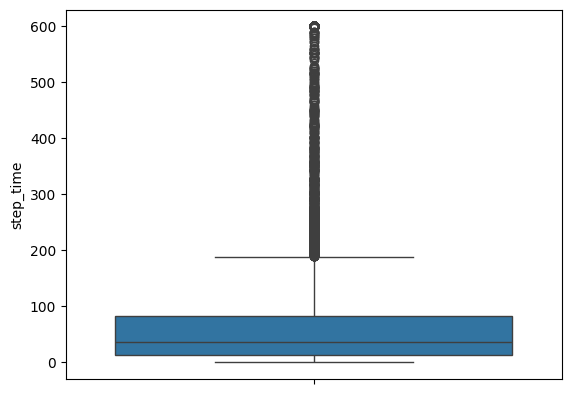

In [ ]:
#running again the boxplot, but this time with 'replaced by 600 sec' outliers
sns.boxplot(  y='step_time', data=df_time2)

In [ ]:
# create series with control and test step_time 
time_test = df_time2[df_time2['Variation'] == 'Test']['step_time']
time_control = df_time2[df_time2['Variation'] == 'Control']['step_time']

In [ ]:
time_test.describe() 

count    5231.000000
mean       75.571401
std       115.658749
min         0.000000
25%        13.000000
50%        36.000000
75%        83.000000
max       600.000000
Name: step_time, dtype: float64

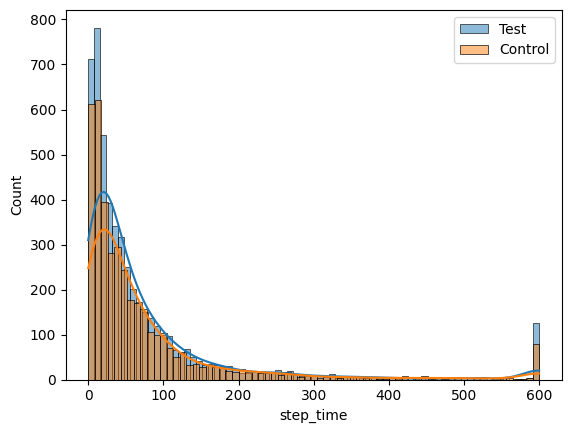

In [ ]:
sns.histplot(time_test, kde=True, label='Test')
sns.histplot(time_control, kde=True, label='Control')

# Add legend
plt.legend()

# Show plot
plt.show()

In [ ]:
time_test.describe()

count    5231.000000
mean       75.571401
std       115.658749
min         0.000000
25%        13.000000
50%        36.000000
75%        83.000000
max       600.000000
Name: step_time, dtype: float64

In [ ]:
time_control.describe()

count    4024.000000
mean       76.599901
std       114.046299
min         0.000000
25%        14.000000
50%        38.000000
75%        84.000000
max       600.000000
Name: step_time, dtype: float64

In [ ]:
# mann whitney test for step time
# H0: test <= control
# H1: test > control
stats.mannwhitneyu(time_test, time_control, alternative='greater')

MannwhitneyuResult(statistic=10353313.5, pvalue=0.9108034068639483)

we cannot reject H0, meaning either test is smaller is there's no significant difference in terms of avg time duration

In [ ]:
df_tr_error = df_error_counter[df_error_counter['variation'] == 'Test']
df_ctrl_error = df_error_counter[df_error_counter['variation'] == 'Control']

In [ ]:
df_time2

,client_id,visit_id,date_time,process_step,Variation,step_ahead,diff,step_time
0,555,637149525_38041617439_716659,2017-04-15 12:57:56,start,Test,NaN,NaN,7.0
1,555,637149525_38041617439_716659,2017-04-15 12:58:03,step_1,Test,2017-04-15 12:57:56,7.0,32.0
2,555,637149525_38041617439_716659,2017-04-15 12:58:35,step_2,Test,2017-04-15 12:58:03,32.0,99.0
3,555,637149525_38041617439_716659,2017-04-15 13:00:14,step_3,Test,2017-04-15 12:58:35,99.0,20.0
5,647,40369564_40101682850_311847,2017-04-12 15:41:28,start,Test,NaN,NaN,7.0
...,...,...,...,...,...,...,...,...
11853,370651,68961774_43618302815_544394,2017-05-14 16:50:03,start,Control,2017-05-14 16:48:39,84.0,82.0
11854,370651,68961774_43618302815_544394,2017-05-14 16:51:25,start,Control,2017-05-14 16:50:03,82.0,5.0
11855,370651,68961774_43618302815_544394,2017-05-14 16:51:30,step_1,Control,2017-05-14 16:51:25,5.0,12.0
11856,370651,68961774_43618302815_544394,2017-05-14 16:51:42,step_2,Control,2017-05-14 16:51:30,12.0,77.0


In [ ]:
df_time2.to_csv('df_time2.csv')

In [ ]:
##Z-test on the error rates

In [ ]:
proportions_ztest(count=[11838, 6358], nobs=[177787,143420], alternative='larger')
#the error count in the test group is significantly larger than the error count on the 
# control group --> which may explain why the process wasn't more efficient and didn't meet
# the required threshold

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=69aefbff-9953-4085-83bf-8937b918b827' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>